In [2]:
from torch.utils.data import DataLoader 
import torch
import matplotlib.pyplot as plt
import pylibnxc
from pyscf import gto, dft, scf 
from kspies import wy, zmp
from dpyscfl.scf import *
from dpyscfl.net import *
from dpyscfl.utils import *
import os, shutil, copy
from ase import Atoms
from ase.units import Bohr, Hartree, kcal, mol
import pickle
from ase.io import read, write
from torchviz import make_dot
import re

kcalmol = kcal/mol
H_to_kcalmol = Hartree/kcalmol

In [3]:
def get_max_epoch(elist):
    splits = [re.split('_e|_c', e) for e in elist]
    es = []
    for s in splits:
        if len(s) == 2:
            es.append(int(s[-1]))
        elif len(s) == 3:
            continue
    return max(es)+1

def epoch_parser(dr, perc=1):
    #split on epoch count and continue count
    split = re.split('_e|_c', dr)
    if len(split) == 2:
        e = int(split[-1])
        c = 0
    elif len(split) == 3:
        c = int(split[-1])
        e = int(split[-2])
    else:
        raise Exception(split)
        
    return e + c*perc 

def load_loss_eval(bdir, lfile = 'loss_dct_MGGA.pckl'):
    sdirs = sorted([i for i in os.listdir(bdir) if os.path.isdir(os.path.join(bdir, i))])
    sdirs = sorted(sdirs, key=len)
    dct = {sd:{} for sd in sdirs}
    for sd in sdirs:
        ep = epoch_parser(sd, perc = get_max_epoch(sdirs)) if len(sdirs) > 1 else 0
        try:
            with open(os.path.join(bdir, sd, lfile), 'rb') as f:
                dct[sd] = [ep, pickle.load(f)]
        except:
            dct.pop(sd, None)
            continue
    return dct
    
bdir = '/home/awills/Documents/Research/swxcd/eval/rxcdw5/single'
#sort alph
tdi  = sorted([i for i in os.listdir(bdir) if os.path.isdir(os.path.join(bdir, i))])
#sort len
tdi = sorted(tdi, key=len)

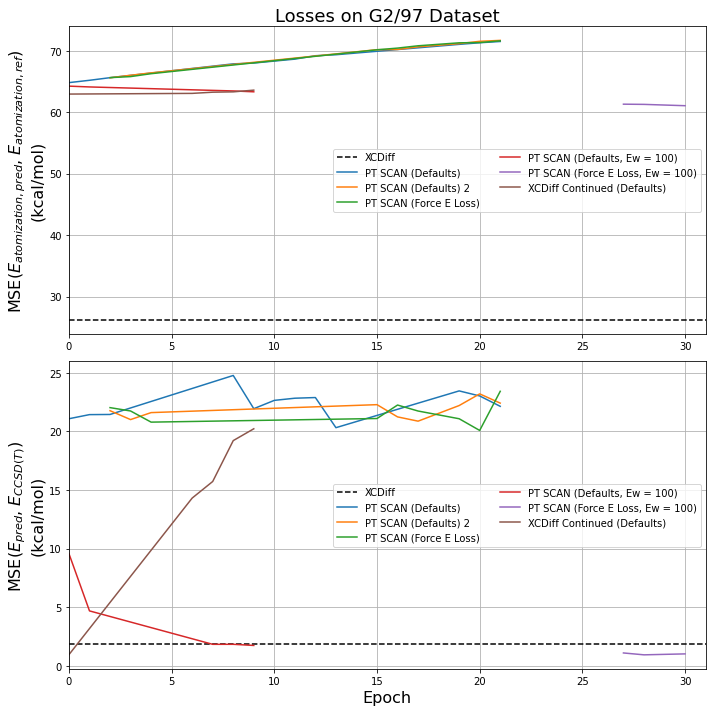

In [11]:
xcdsetp = '/home/awills/Documents/Research/swxcd/eval/xcdset'
pts = os.path.join(xcdsetp, 'ptscan')
pts2 = os.path.join(xcdsetp, 'pts2')
pts2el = os.path.join(xcdsetp, 'pts2_el')
pts2e100 = os.path.join(xcdsetp, 'pts2_ew100')
pts2el100 = os.path.join(xcdsetp, 'pts2_ewl100')
xcdset = os.path.join(xcdsetp, 'xcdiff')
td1 = load_loss_eval(bdir = pts)
td2 = load_loss_eval(bdir = pts2)
td3 = load_loss_eval(bdir = pts2el)
td4 = load_loss_eval(bdir = pts2e100)
td5 = load_loss_eval(bdir = pts2el100)
td6 = load_loss_eval(bdir = xcdset)

xcdp = '/home/awills/Documents/Research/swxcd/eval/xcdiff_orig'
xcd = load_loss_eval(bdir = xcdp)


f = plt.figure(figsize=(10,10))
aax = f.add_subplot(211)
eax = f.add_subplot(212, sharex = aax)
aax.grid()
eax.grid()
labels2 = {'XCDiff':xcd,
           'PT SCAN (Defaults)':td1,
         'PT SCAN (Defaults) 2':td2,
         'PT SCAN (Force E Loss)':td3,
         'PT SCAN (Defaults, Ew = 100)':td4,
         'PT SCAN (Force E Loss, Ew = 100)':td5,
          'XCDiff Continued (Defaults)':td6}
labels=labels2
scale = H_to_kcalmol
for k, v in labels.items():
    if k == 'XCDiff':
        x = np.linspace(0, 100)
        ay = scale*v['MODEL_MGGA'][1]['atm']*np.ones_like(x)
        ey = scale*v['MODEL_MGGA'][1]['E']*np.ones_like(x)
        aax.plot(x, ay, 'k--', label=k)
        eax.plot(x, ey, 'k--', label=k)
    else:
        xs = []
        ays = []
        eys = []
        for ik, v in labels[k].items():
            xs.append(v[0])
            ays.append(v[1]['atm'])
            eys.append(v[1]['E'])
        aax.plot(xs, scale*np.array(ays), label=k)
        eax.plot(xs, scale*np.array(eys), label=k)
        
aax.legend(ncol=2)
eax.legend(ncol=2)
#aax.set_ylim(0.04, 0.08)
#eax.set_ylim(0, 0.25)
aax.set_xlim(0,31)

eax.set_ylabel('MSE($E_{pred}$, $E_{CCSD(T)}$)\n(kcal/mol)', fontsize=16)
aax.set_ylabel('MSE($E_{atomization, pred}$, $E_{atomization, ref}$)\n(kcal/mol)', fontsize=16)
eax.set_xlabel('Epoch', fontsize=16)
aax.set_title('Losses on G2/97 Dataset', fontsize=18)
plt.tight_layout()

In [4]:
xcdtst = '/home/awills/Documents/Research/swxcd/eval/test_subset2/xcd_eval'
tstp1 = '/home/awills/Documents/Research/swxcd/eval/test_subset/xcd0'
tstp2 = '/home/awills/Documents/Research/swxcd/eval/test_subset/xcd1'
tstp3 = '/home/awills/Documents/Research/swxcd/eval/test_subset/pts1'
tstp4 = '/home/awills/Documents/Research/swxcd/eval/test_subset2/pts1'
tstp5 = '/home/awills/Documents/Research/swxcd/eval/test_subset2/pts3'
tstp6 = '/home/awills/Documents/Research/swxcd/eval/test_subset2/pts4'
tstp7 = '/home/awills/Documents/Research/swxcd/eval/test_subset2/pts5'
tstp8 = '/home/awills/Documents/Research/swxcd/eval/test_subset2/pts6'
tstp9 = '/home/awills/Documents/Research/swxcd/eval/test_subset2/pts7'
tstp10 = '/home/awills/Documents/Research/swxcd/eval/test_subset2/pts8'
tstp11 = '/home/awills/Documents/Research/swxcd/eval/test_subset2/pts9'
tstp12 = '/home/awills/Documents/Research/swxcd/eval/test_subset2/pts10'
tstp13 = '/home/awills/Documents/Research/swxcd/eval/test_subset2/pts11'
tstp14 = '/home/awills/Documents/Research/swxcd/eval/test_subset2/pts12'
tstp15 = '/home/awills/Documents/Research/swxcd/eval/test_subset2/pts13'
xcdp = '/home/awills/Documents/Research/swxcd/eval/xcdiff_orig'
rxcdp = '/home/awills/Documents/Research/swxcd/eval/rxcd5'
rxcdwp = '/home/awills/Documents/Research/swxcd/eval/rxcdw5'

pt = '/home/awills/Documents/Research/swxcd/eval/pt'
pts = 'scan'
ptp = 'popscan'
pte = 'epopscan'
pte2 = 'epop2scan'
ptw1 = 'epw1scan'
pter = 'epe1r20scan'
lfile = 'loss_dct_MGGA.pckl'
cp = ''
sp = 'scan'
sh = 'scanhyb'
dl = 'dloss'
sl = 'single'
dbl = 'double'

xcdt = load_loss_eval(bdir = xcdtst)
tstd1 = load_loss_eval(bdir = tstp1)
tstd2 = load_loss_eval(bdir = tstp2)
tstd3 = load_loss_eval(bdir = tstp3)
tstd4 = load_loss_eval(bdir = tstp4)
tstd5 = load_loss_eval(bdir = tstp5)
tstd6 = load_loss_eval(bdir = tstp6)
tstd7 = load_loss_eval(bdir = tstp7)
tstd8 = load_loss_eval(bdir = tstp8)
tstd9 = load_loss_eval(bdir = tstp9)
tstd10 = load_loss_eval(bdir = tstp10)
tstd11 = load_loss_eval(bdir = tstp11)
tstd12 = load_loss_eval(bdir = tstp12)
tstd13 = load_loss_eval(bdir = tstp13)
tstd14 = load_loss_eval(bdir = tstp14)
tstd15 = load_loss_eval(bdir = tstp15)

xcd = load_loss_eval(bdir = xcdp)
rsd = load_loss_eval(bdir = os.path.join(rxcdp, sp, dl), lfile = 'loss_dct_MGGA.pckl')
rss = load_loss_eval(bdir = os.path.join(rxcdp, sp, sl), lfile = 'loss_dct_MGGA.pckl')
rwsd = load_loss_eval(bdir = os.path.join(rxcdwp, sp, dl), lfile = 'loss_dct_MGGA.pckl')
rwcd = load_loss_eval(bdir = os.path.join(rxcdwp, dl), lfile = 'loss_dct_MGGA.pckl')
rwcs = load_loss_eval(bdir = os.path.join(rxcdwp, sl), lfile = 'loss_dct_MGGA.pckl')
rwcdb = load_loss_eval(bdir = os.path.join(rxcdwp, dbl), lfile = 'loss_dct_MGGA.pckl')

ptsord = load_loss_eval(bdir = os.path.join(pt, tstp5), lfile='loss_dct_MGGA.pckl')

ptsl = load_loss_eval(bdir = os.path.join(pt, pts), lfile=lfile)
ptpl = load_loss_eval(bdir = os.path.join(pt, ptp), lfile=lfile)
ptel = load_loss_eval(bdir = os.path.join(pt, pte), lfile=lfile)
pte2l = load_loss_eval(bdir = os.path.join(pt, pte2), lfile=lfile)
ptwl = load_loss_eval(bdir = os.path.join(pt, ptw1), lfile=lfile)
pterl = load_loss_eval(bdir = os.path.join(pt, pter), lfile=lfile)

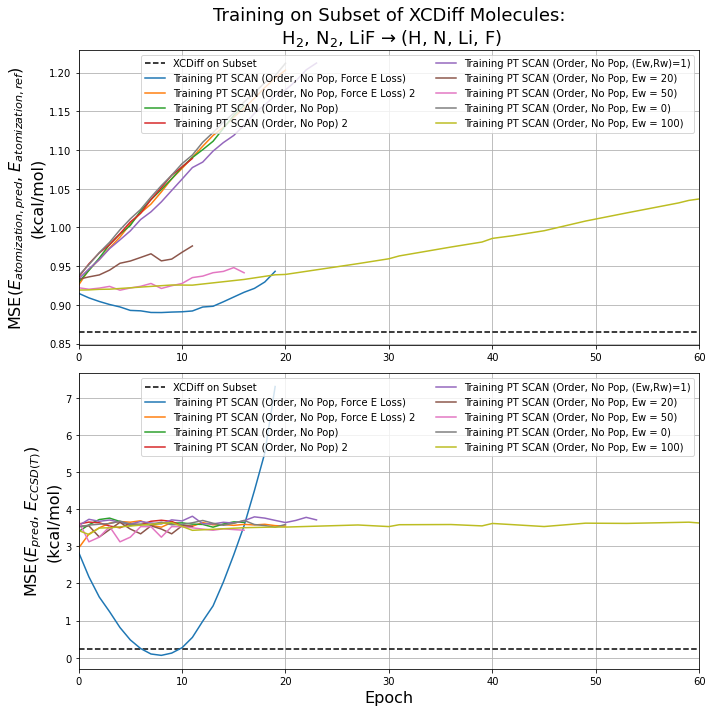

In [6]:
f = plt.figure(figsize=(10,10))
aax = f.add_subplot(211)
eax = f.add_subplot(212, sharex = aax)
aax.grid()
eax.grid()
labels2 = {'XCDiff on Subset':xcdt,
          #'Training XCDiff': tstd1,
         #'Training XCDiff (2)':tstd2,
         'Training Pre-trained SCAN':tstd3,
         'Training PT SCAN (AO)':tstd4,
         'Training PT SCAN (Order Change)':tstd5,
         'Training PT SCAN (Order, No Pop)':tstd6,
         'Training PT SCAN (Order, No Pop, Force E Loss)':tstd7,
         'Training PT SCAN (Order, No Pop, Force E Loss) 2':tstd8}
labels1 = {'XCDiff on Subset':xcdt,
          #'Training XCDiff': tstd1,
         #'Training XCDiff (2)':tstd2,
         #'Training Pre-trained SCAN':tstd3,
         #'Training PT SCAN (AO)':tstd4,
         #'Training PT SCAN (Order Change)':tstd5,
         #'Training PT SCAN (Order, No Pop)':tstd6,
         'Training PT SCAN (Order, No Pop, Force E Loss)':tstd7,
         'Training PT SCAN (Order, No Pop, Force E Loss) 2':tstd8,
           'Training PT SCAN (Order, No Pop)' : tstd9,
           'Training PT SCAN (Order, No Pop) 2': tstd10,
           'Training PT SCAN (Order, No Pop, (Ew,Rw)=1)': tstd11,
           'Training PT SCAN (Order, No Pop, Ew = 20)': tstd12,
           'Training PT SCAN (Order, No Pop, Ew = 50)': tstd13,
           'Training PT SCAN (Order, No Pop, Ew = 0)':tstd14,
           'Training PT SCAN (Order, No Pop, Ew = 100)':tstd15
         }
labels=labels1
scale = H_to_kcalmol
for k, v in labels.items():
    if k == 'XCDiff on Subset':
        x = np.linspace(0, 100)
        ay = scale*v['MODEL_MGGA'][1]['atm']*np.ones_like(x)
        ey = scale*v['MODEL_MGGA'][1]['E']*np.ones_like(x)
        aax.plot(x, ay, 'k--', label=k)
        eax.plot(x, ey, 'k--', label=k)
    else:
        xs = []
        ays = []
        eys = []
        for ik, v in labels[k].items():
            xs.append(v[0])
            ays.append(v[1]['atm'])
            eys.append(v[1]['E'])
        aax.plot(xs, scale*np.array(ays), label=k)
        eax.plot(xs, scale*np.array(eys), label=k)
        
aax.legend(ncol=2)
eax.legend(ncol=2)
#aax.set_ylim(0.04, 0.08)
#eax.set_ylim(0, 0.25)
aax.set_xlim(0,60)

eax.set_ylabel('MSE($E_{pred}$, $E_{CCSD(T)}$)\n(kcal/mol)', fontsize=16)
aax.set_ylabel('MSE($E_{atomization, pred}$, $E_{atomization, ref}$)\n(kcal/mol)', fontsize=16)
eax.set_xlabel('Epoch', fontsize=16)
aax.set_title('Training on Subset of XCDiff Molecules:\n H$_2$, N$_2$, LiF $\\to$ (H, N, Li, F)', fontsize=18)
plt.tight_layout()

In [14]:
xcdt

{'MODEL_MGGA_e00': [0, {'E': tensor(0.0004), 'atm': tensor(0.0014)}]}

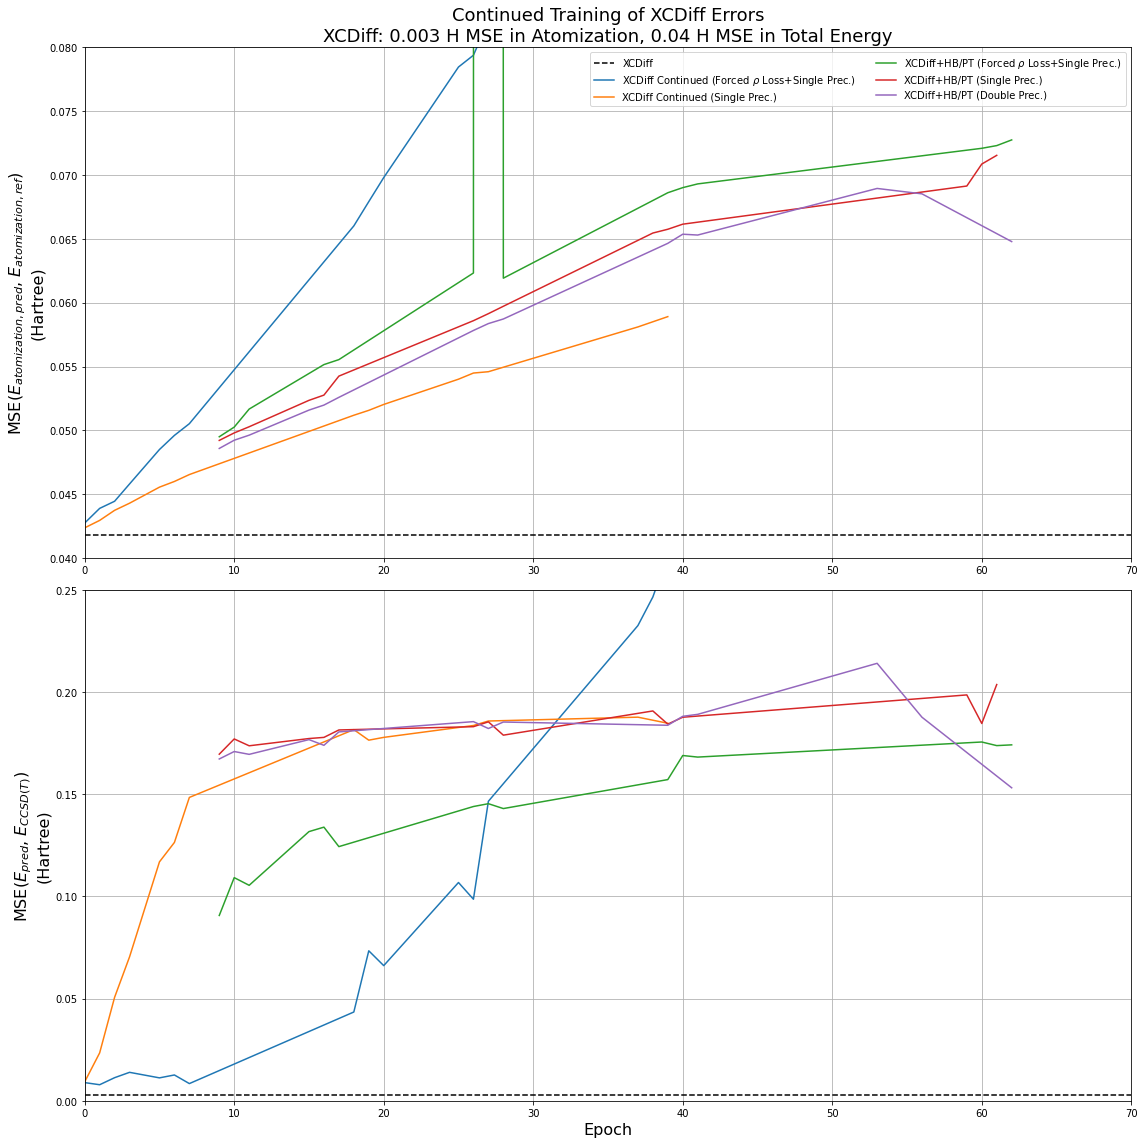

In [14]:
f = plt.figure(figsize=(16,16))
aax = f.add_subplot(211)
eax = f.add_subplot(212, sharex = aax)
aax.grid()
eax.grid()

scale = 1

labels = {'XCDiff':xcd,
         #'XCDiff Continued (SCAN+$\\rho$ Loss+Single Prec.)':rsd,
         #'XCDiff Continued (SCAN+Single Prec.)':rss,
         #'XCDiff+HB/PT (SCAN+$\\rho$ Loss+Single Prec.)':rwsd,
         #'XCDiff+HB/PT (CCSD(T)+$\\rho$ Loss+Single Prec.)':rwcd,
         #'XCDiff+HB/PT (CCSD(T)+Single Prec.)':rwcs,
         #'XCDiff+HB/PT (CCSD(T)+Double Prec.)':rwcdb,
        'XCDiff Continued (Forced $\\rho$ Loss+Single Prec.)':rsd,
         'XCDiff Continued (Single Prec.)':rss,
         'XCDiff+HB/PT (Forced $\\rho$ Loss+Single Prec.)':rwsd,
         'XCDiff+HB/PT (Forced $\\rho$ Loss+Single Prec.)':rwcd,
         'XCDiff+HB/PT (Single Prec.)':rwcs,
         'XCDiff+HB/PT (Double Prec.)':rwcdb}
for k, v in labels.items():
    if k == 'XCDiff':
        x = np.linspace(0, 100)
        ay = v['MODEL_MGGA'][1]['atm']*np.ones_like(x)
        ey = v['MODEL_MGGA'][1]['E']*np.ones_like(x)
        aax.plot(x, scale*ay, 'k--', label=k)
        eax.plot(x, scale*ey, 'k--', label=k)
    else:
        xs = []
        ays = []
        eys = []
        for ik, v in labels[k].items():
            xs.append(v[0])
            ays.append(v[1]['atm'])
            eys.append(v[1]['E'])
        aax.plot(xs, scale*np.array(ays), label=k)
        eax.plot(xs, scale*np.array(eys), label=k)

#aax.set_yscale('log')
#eax.set_yscale('log')

aax.legend(ncol=2)
aax.set_ylim(0.04, 0.08)
eax.set_ylim(0, 0.25)
aax.set_xlim(0,70)
eax.set_xlim(0,70)

eax.set_ylabel('MSE($E_{pred}$, $E_{CCSD(T)}$)\n(Hartree)', fontsize=16)
aax.set_ylabel('MSE($E_{atomization, pred}$, $E_{atomization, ref}$)\n(Hartree)', fontsize=16)
eax.set_xlabel('Epoch', fontsize=16)
aax.set_title('Continued Training of XCDiff Errors\nXCDiff: 0.003 H MSE in Atomization, 0.04 H MSE in Total Energy', fontsize=18)
plt.tight_layout()

In [13]:
xcd

{'MODEL_MGGA': [0, {'E': tensor(0.0030), 'atm': tensor(0.0418)}]}

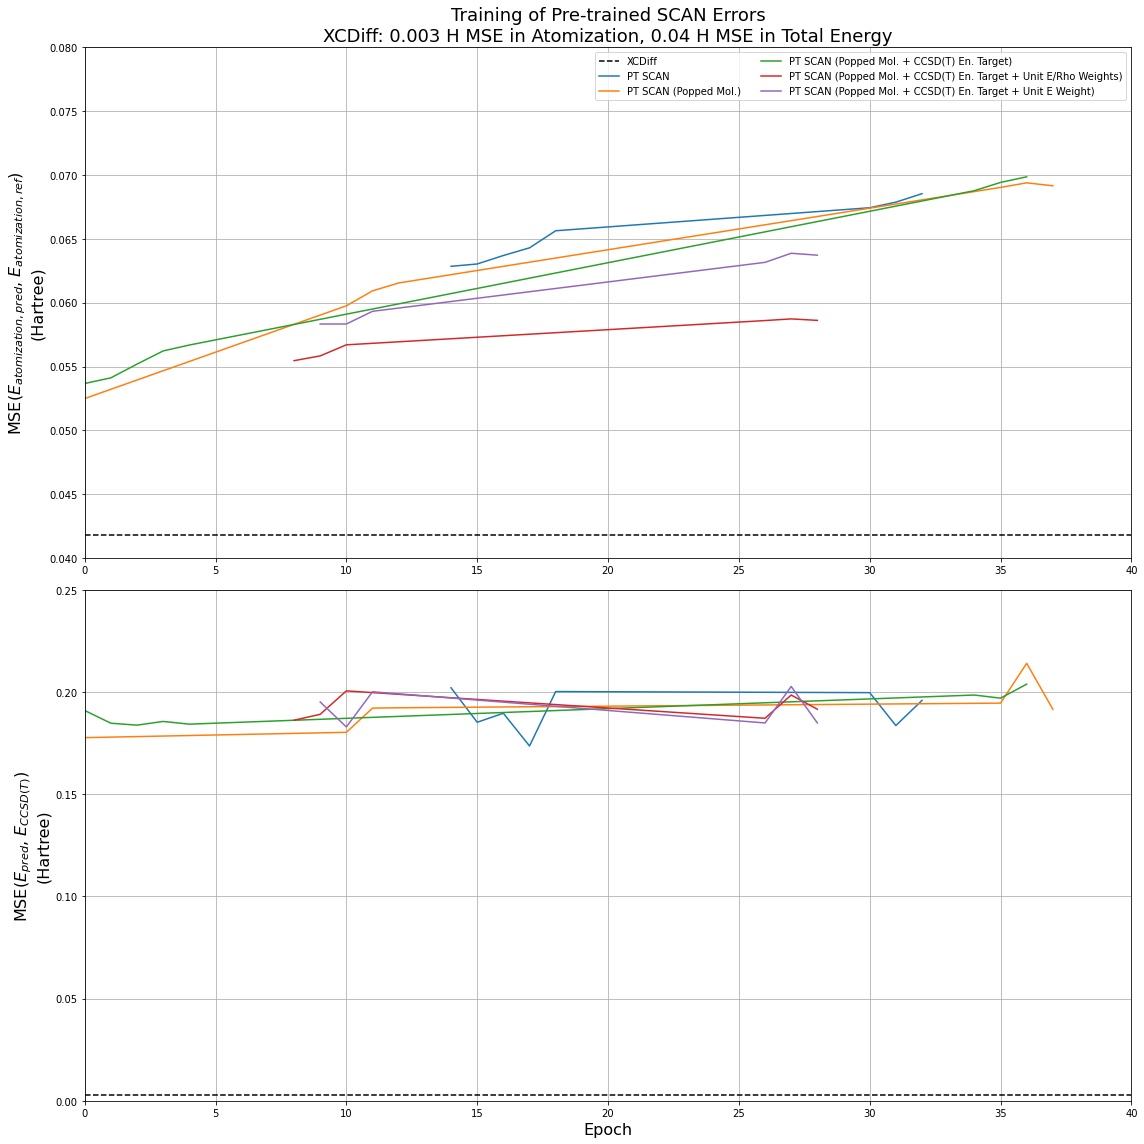

In [20]:
f = plt.figure(figsize=(16,16))
aax = f.add_subplot(211)
eax = f.add_subplot(212, sharex = aax)
aax.grid()
eax.grid()
labels = {'XCDiff':xcd,
         'PT SCAN': ptsl,
         'PT SCAN (Popped Mol.)':ptpl,
         'PT SCAN (Popped Mol. + CCSD(T) En. Target)':ptel,
         'PT SCAN (Popped Mol. + CCSD(T) En. Target)':pte2l,
         'PT SCAN (Popped Mol. + CCSD(T) En. Target + Unit E/Rho Weights)':ptwl,
         'PT SCAN (Popped Mol. + CCSD(T) En. Target + Unit E Weight)':pterl}
for k, v in labels.items():
    if k == 'XCDiff':
        x = np.linspace(0, 100)
        ay = v['MODEL_MGGA'][1]['atm']*np.ones_like(x)
        ey = v['MODEL_MGGA'][1]['E']*np.ones_like(x)
        aax.plot(x, ay, 'k--', label=k)
        eax.plot(x, ey, 'k--', label=k)
    else:
        xs = []
        ays = []
        eys = []
        for ik, v in labels[k].items():
            xs.append(v[0])
            ays.append(v[1]['atm'])
            eys.append(v[1]['E'])
        aax.plot(xs, ays, label=k)
        eax.plot(xs, eys, label=k)

#aax.set_yscale('log')
#eax.set_yscale('log')

aax.legend(ncol=2)
aax.set_ylim(0.04, 0.08)
eax.set_ylim(0, 0.25)
aax.set_xlim(0,40)
eax.set_xlim(0,40)

eax.set_ylabel('MSE($E_{pred}$, $E_{CCSD(T)}$)\n(Hartree)', fontsize=16)
aax.set_ylabel('MSE($E_{atomization, pred}$, $E_{atomization, ref}$)\n(Hartree)', fontsize=16)
eax.set_xlabel('Epoch', fontsize=16)
aax.set_title('Training of Pre-trained SCAN Errors\nXCDiff: 0.003 H MSE in Atomization, 0.04 H MSE in Total Energy', fontsize=18)
plt.tight_layout()

In [21]:
print(tdi[7], epoch_parser(tdi[7], perc=2))

MODEL_MGGA_e14_c2 18


In [2]:
ref = read('/home/awills/Documents/Research/swxcd/seawulf/g2_97_3/results.traj', ':')
xcdp = '/home/awills/Documents/Research/swxcd/eval/xcdiff/g2_97/preds_2'
xcdcp = '/home/awills/Documents/Research/swxcd/eval/xcdiff_c/g2_97/preds_d2tzvpd'
xcdcpd = '/home/awills/Documents/Research/swxcd/eval/xcdiff_c/g2_97/predsdoub_d2tzvpd'
xcdsw1 = '/home/awills/Documents/Research/swxcd/eval/xcdsw1/g2_97/preds_d2tzvpd'
xcdsw3 = '/home/awills/Documents/Research/swxcd/eval/xcdsw3/g2_97/preds_d2tzvpd'
xcdsw12 = '/home/awills/Documents/Research/swxcd/eval/xcdsw1/g2_97/preds2_d2tzvpd'
xcdsw32 = '/home/awills/Documents/Research/swxcd/eval/xcdsw3/g2_97/preds2_d2tzvpd'
xcdsf1 = '/home/awills/Documents/Research/swxcd/eval/xcdsymfrac/abfrac/swmg1/g2_97/preds_d2tzvpd'
xcdsf3 = '/home/awills/Documents/Research/swxcd/eval/xcdsymfrac/abfrac/swmg3/g2_97/preds_d2tzvpd'
xcdsf12 = '/home/awills/Documents/Research/swxcd/eval/xcdsymfrac/abfrac/swmg1/g2_97/preds2_d2tzvpd'
xcdsf32 = '/home/awills/Documents/Research/swxcd/eval/xcdsymfrac/abfrac/swmg3/g2_97/preds2_d2tzvpd'

pts = '/home/awills/Documents/Research/swxcd/eval/ptscan/g2_97/preds_d2tzvpd'
pts2 = '/home/awills/Documents/Research/swxcd/eval/ptscan/g2_97/preds2_d2tzvpd'
ptsd = '/home/awills/Documents/Research/swxcd/eval/ptscan/double/g2_97/preds_d2tzvpd'
ptsd2 = '/home/awills/Documents/Research/swxcd/eval/ptscan/double/g2_97/preds2_d2tzvpd'

#paths = [xcdp, xcdfp, RFP, FRP, FR1P, xcdcp]
paths = [xcdp, xcdcp, xcdcpd, xcdsw1, xcdsw12, xcdsw3, xcdsw32, xcdsf1, xcdsf3, xcdsf12, xcdsf32,
        pts, pts2, ptsd, ptsd2]
es = {p:[] for p in paths}
ref_es = [at.calc.results['energy']/Hartree for at in ref]
for idx,atom in enumerate(ref):
    pckl = '{}_{}.pckl'.format(idx, atom.symbols)
    for key in list(es.keys()):
        if idx == 0:
            print(key)
        with open(key+'/{}'.format(pckl), 'rb') as f:
            e = pickle.load(f)
        es[key].append(e['E'])

n_atoms = [len(at.positions) for at in ref]
def mse(ref_es, pred_es, n_atoms):
    err = []
    for idx in range(len(ref_es)):
        ref = ref_es[idx]
        pred = pred_es[idx]
        nat = n_atoms[idx]
        err.append((ref-pred)**2)
    mse = np.mean(err)
    std = np.std(err)
    return ([np.sqrt(ierr) for ierr in err], mse, std)

/home/awills/anaconda3/envs/rsrch/lib/python3.7/site-packages/ase/io/jsonio.py:58: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  a = np.array(obj)


/home/awills/Documents/Research/swxcd/eval/xcdiff/g2_97/preds_2
/home/awills/Documents/Research/swxcd/eval/xcdiff_c/g2_97/preds_d2tzvpd
/home/awills/Documents/Research/swxcd/eval/xcdiff_c/g2_97/predsdoub_d2tzvpd
/home/awills/Documents/Research/swxcd/eval/xcdsw1/g2_97/preds_d2tzvpd
/home/awills/Documents/Research/swxcd/eval/xcdsw1/g2_97/preds2_d2tzvpd
/home/awills/Documents/Research/swxcd/eval/xcdsw3/g2_97/preds_d2tzvpd
/home/awills/Documents/Research/swxcd/eval/xcdsw3/g2_97/preds2_d2tzvpd
/home/awills/Documents/Research/swxcd/eval/xcdsymfrac/abfrac/swmg1/g2_97/preds_d2tzvpd
/home/awills/Documents/Research/swxcd/eval/xcdsymfrac/abfrac/swmg3/g2_97/preds_d2tzvpd
/home/awills/Documents/Research/swxcd/eval/xcdsymfrac/abfrac/swmg1/g2_97/preds2_d2tzvpd
/home/awills/Documents/Research/swxcd/eval/xcdsymfrac/abfrac/swmg3/g2_97/preds2_d2tzvpd
/home/awills/Documents/Research/swxcd/eval/ptscan/g2_97/preds_d2tzvpd
/home/awills/Documents/Research/swxcd/eval/ptscan/g2_97/preds2_d2tzvpd
/home/awills/Do

In [4]:
errd = {key: mse(ref_es, val, n_atoms) for key,val in es.items()}
labels = {xcdp: 'XCDiff',
          xcdcp:'XCDiff (Continued, 18 Epochs)',
          xcdcpd:'XCDiff (Continued, Double Prec.)',
          xcdsw1:'XCDiff+HB/PT (Grid 1)',
          xcdsw12:'XCDiff+HB/PT (Grid 1, 2 Days)',
          xcdsw3:'XCDiff+HB/PT (Grid 3)',
          xcdsw32:'XCDiff+HB/PT (Grid 3, 2 Days)',
         xcdsf1: 'XCDiff+F (Full Net, Grid 1)',
       xcdsf3: 'XCDiff+F (Full Net, Grid 3)',
         xcdsf12: 'XCDiff+F (Continued, Grid 1)',
       xcdsf32: 'XCDiff+F (Continued, Grid 3)',
         pts:'Pre-Train SCAN Start',
         pts2:'Pre-Train SCAN Start (Continued)',
         ptsd:'Pre-Train SCAN Start (Double)',
         ptsd2:'Pre-Train SCAN Start (Double, Continued)'}

def errcomp(err1, err2, atoms):
    inds = [i for i in range(len(e1)) if e1[i] < e2[i] ]
    better = [atoms[i] for i in inds]
    return better

In [9]:
e1 = errd[xcdsw32][0]
e2 = errd[xcdp][0]
b = errcomp(e1, e2, ref)
bf = [ib.get_chemical_formula() for ib in b]
','.join(bf)

'CO,HF,CO2,H2O,CHO,N2O,NO2,CHF3,CF2O,CH2O,H2O2,CH2O2,C2F3N,CH2F2,CH3O,C2H2O,C2H4O2,NO,C2H4O2,CH3NO2,C2H5NO,C2H3FO,C2H3F,HO,N2,O2,CH3NO2,C2H2O2,O3'

/home/awills/Documents/Research/swxcd/eval/xcdiff/g2_97/preds_2 0.003096511376351026 0
XCDiff:
0.0031
/home/awills/Documents/Research/swxcd/eval/xcdiff_c/g2_97/preds_d2tzvpd 0.076323711272367 1
XCDiff (Continued, 18 Epochs):
0.0763
/home/awills/Documents/Research/swxcd/eval/xcdiff_c/g2_97/predsdoub_d2tzvpd 0.08739349792690948 2
XCDiff (Continued, Double Prec.):
0.0874
/home/awills/Documents/Research/swxcd/eval/xcdsw1/g2_97/preds_d2tzvpd 0.13611175905445214 3
XCDiff+HB/PT (Grid 1):
0.1361
/home/awills/Documents/Research/swxcd/eval/xcdsw1/g2_97/preds2_d2tzvpd 0.20221368352047445 4
XCDiff+HB/PT (Grid 1, 2 Days):
0.2022
/home/awills/Documents/Research/swxcd/eval/xcdsw3/g2_97/preds_d2tzvpd 0.06027217343528113 5
XCDiff+HB/PT (Grid 3):
0.0603
/home/awills/Documents/Research/swxcd/eval/xcdsw3/g2_97/preds2_d2tzvpd 0.12942933733179193 6
XCDiff+HB/PT (Grid 3, 2 Days):
0.1294
/home/awills/Documents/Research/swxcd/eval/xcdsymfrac/abfrac/swmg1/g2_97/preds_d2tzvpd 0.19018296876037788 7
XCDiff+F (Full

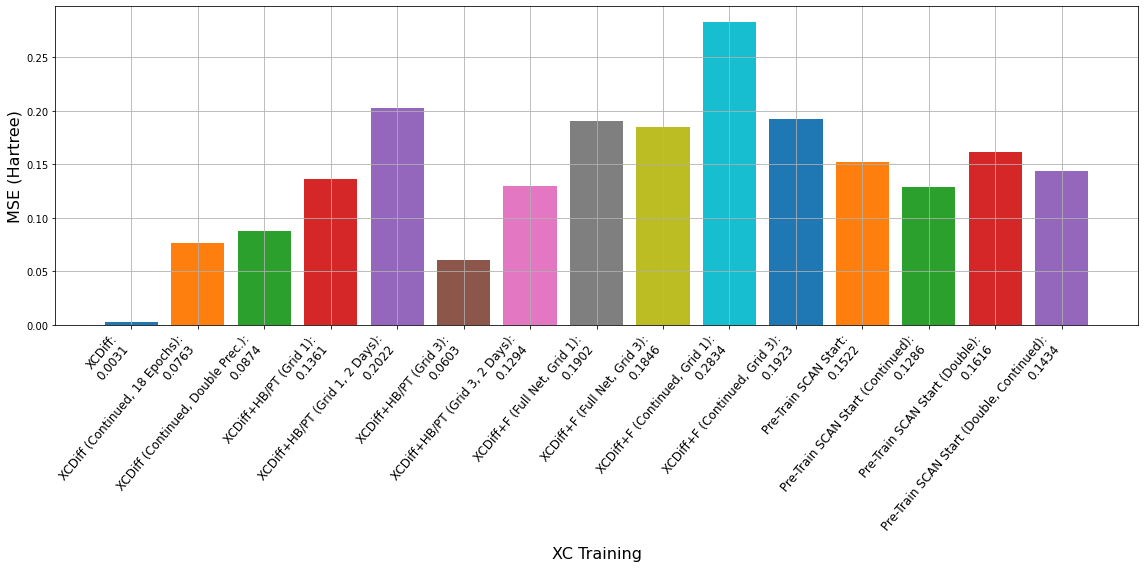

In [18]:
f = plt.figure(figsize=(16,8))
ax = f.add_subplot(111)
count = 0
xtlabs = []
ax.grid()
for k,v in errd.items():
    print(k, v[1], count)
    lab = labels[k]+':\n{:3.4f}'.format(v[1])
    print(lab)
    ax.bar(count, v[1], label=lab)
    xtlabs.append(lab)
    count += 1
ax.set_xticks(np.arange(0, count))
ax.set_xticklabels(xtlabs, fontsize=12, rotation=50, ha='right')
ax.set_ylabel("MSE (Hartree)", fontsize=16)
ax.set_xlabel("XC Training", fontsize=16)
plt.tight_layout()

In [13]:
np.arange(1, count)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])

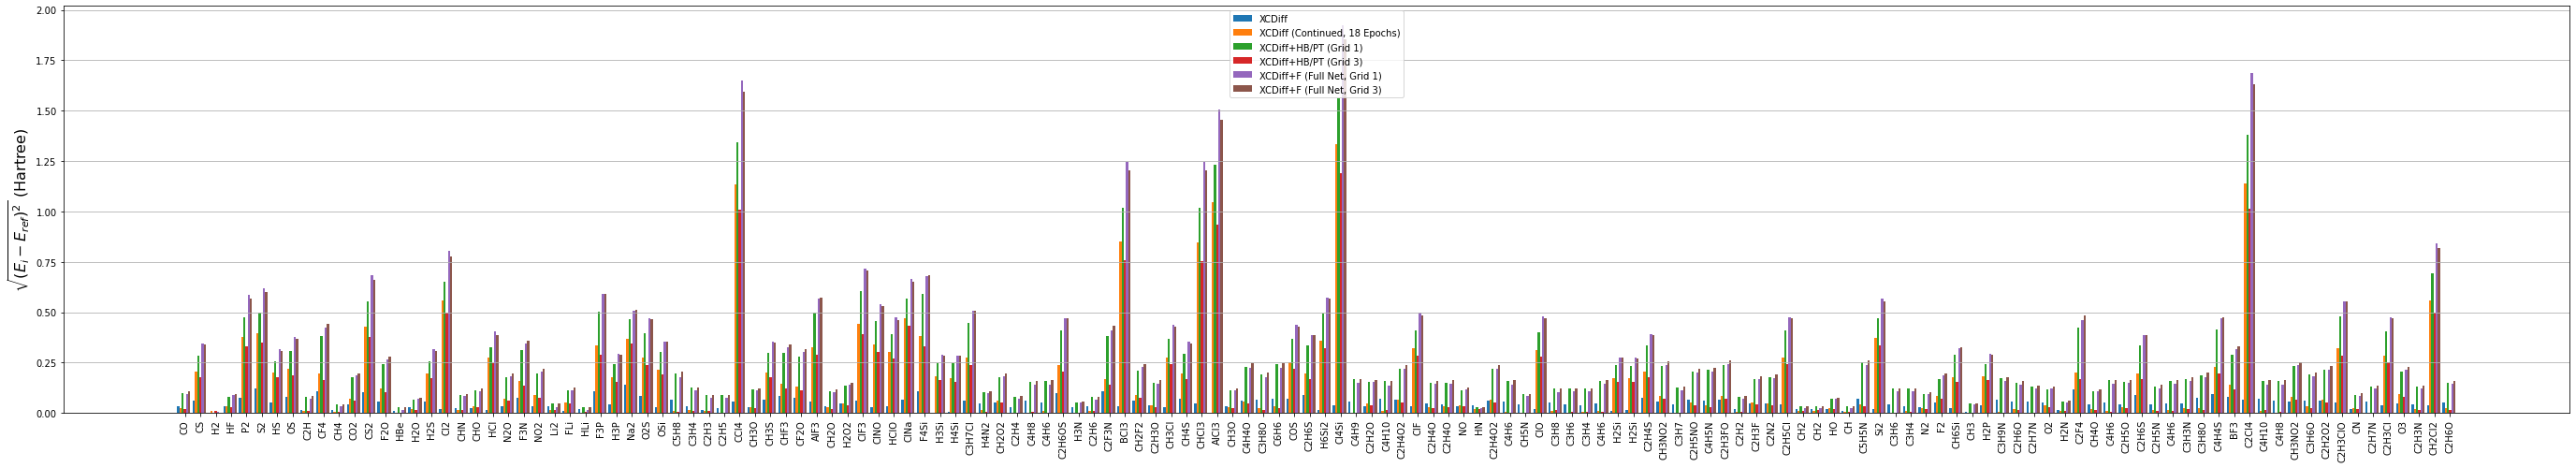

In [27]:
f = plt.figure(figsize=(48,8))
ax = f.add_subplot(111)
ax.grid()
ax.xaxis.grid(False)
def gen_xs_bar(*args, **kwargs):
    midsep = kwargs.get('midsep', 1)
    width = kwargs.get('width', midsep/(len(args)+2))
    xs = []
    start = -len(args)//2
    for iarg in range(len(args)):
        arg = args[iarg]
        argxs = []
        for igroup in range(len(arg)):
            argxs.append(igroup*midsep+start*width)
        start += 1
        xs.append(argxs)
    return xs
midsep = len(errd)+1
width = 1
errs = [(labels[k], errd[k][0]) for k in sorted(list(errd.keys()))]
labs = [i[0] for i in errs]
errp = [i[1] for i in errs]
xs = gen_xs_bar(*errp, width=width, midsep=midsep)
for i in range(len(xs)):
    x = xs[i]
    e = errp[i]
    ax.bar(x, e, width=width, label=labs[i])
ax.set_xticks([midsep*i for i in range(len(ref))])
ax.set_xticklabels([at.get_chemical_formula() for at in ref], rotation=90)
ax.set_ylabel('$\\sqrt{(E_i-E_{ref})^2}$ (Hartree)', fontsize=16)
plt.legend(loc='upper center')
plt.show()

In [14]:
x

[-0.3, 1.2, 2.7, 4.2, 5.7, 7.2]

In [22]:
#ref prepared in eV, not hartree. scale down
scale = Hartree
ref = read('/home/awills/Documents/Research/swxcd/seawulf/g2_97_3/results.traj', ':')
m10 = '/home/awills/Documents/Research/swxcd/eval/test/g2_97/preds10'
m11 = '/home/awills/Documents/Research/swxcd/eval/test/g2_97/preds11'
m12 = '/home/awills/Documents/Research/swxcd/eval/test/g2_97/preds12'
m20 = '/home/awills/Documents/Research/swxcd/eval/test/g2_97/preds20'
m21 = '/home/awills/Documents/Research/swxcd/eval/test/g2_97/preds21'
xcdp = '/home/awills/Documents/Research/swxcd/eval/xcdiff/g2_97/preds_2'

xcdw1 = '/home/awills/Documents/Research/swxcd/eval/xcdw5/g2_97/preds_e11'
xcdw2 = '/home/awills/Documents/Research/swxcd/eval/xcdw5/g2_97/preds_e29_d4'
xcdw3 = '/home/awills/Documents/Research/swxcd/eval/xcdw5/g2_97/preds_e28_d2_doub'

#paths = [xcdp, xcdfp, RFP, FRP, FR1P, xcdcp]
paths = [xcdp, m11, m12, xcdw1, xcdw2, xcdw3]
es = {p:[] for p in paths}
ref_es = [at.calc.results['energy']/scale for at in ref]
for idx,atom in enumerate(ref):
    pckl = '{}_{}.pckl'.format(idx, atom.symbols)
    for key in list(es.keys()):
        if idx == 0:
            print(key)
        with open(key+'/{}'.format(pckl), 'rb') as f:
            e = pickle.load(f)
        es[key].append(e['E'])

n_atoms = [len(at.positions) for at in ref]
def mse(ref_es, pred_es, n_atoms):
    err = []
    for idx in range(len(ref_es)):
        ref = ref_es[idx]
        pred = pred_es[idx]
        nat = n_atoms[idx]
        err.append((ref-pred)**2)
    mse = np.mean(err)
    std = np.std(err)
    return ([np.sqrt(ierr) for ierr in err], mse, std)

errd = {key: mse(ref_es, val, n_atoms) for key,val in es.items()}
labels = {xcdp: 'XCDiff',
          m10:'XCDiff (Continued, 1 Epochs)',
          m11:'XCDiff (Continued, 20 Epochs)',
          m12:'XCDiff (Continued, 2 Days)',
          m20:'XCDiff 20',
          m21:'XCDiff 21',
         xcdw1:'XCDiff+HB/PT (11 Epochs)',
         xcdw2:'XCDiff+HB/PT (40 Epochs)',
         xcdw3:'XCDiff+HB/PT (28 Epochs, Double)'}

def errcomp(err1, err2, atoms):
    inds = [i for i in range(len(e1)) if e1[i] < e2[i] ]
    better = [atoms[i] for i in inds]
    return better

/home/awills/Documents/Research/swxcd/eval/xcdiff/g2_97/preds_2
/home/awills/Documents/Research/swxcd/eval/test/g2_97/preds11
/home/awills/Documents/Research/swxcd/eval/test/g2_97/preds12
/home/awills/Documents/Research/swxcd/eval/xcdw5/g2_97/preds_e11
/home/awills/Documents/Research/swxcd/eval/xcdw5/g2_97/preds_e29_d4
/home/awills/Documents/Research/swxcd/eval/xcdw5/g2_97/preds_e28_d2_doub


/home/awills/Documents/Research/swxcd/eval/xcdiff/g2_97/preds_2 0.003096511376351026 0
XCDiff:
0.0031
/home/awills/Documents/Research/swxcd/eval/test/g2_97/preds11 0.002067823568022793 1
XCDiff (Continued, 20 Epochs):
0.0021
/home/awills/Documents/Research/swxcd/eval/test/g2_97/preds12 0.004365691925246343 2
XCDiff (Continued, 2 Days):
0.0044
/home/awills/Documents/Research/swxcd/eval/xcdw5/g2_97/preds_e11 0.006479861451883268 3
XCDiff+HB/PT (11 Epochs):
0.0065
/home/awills/Documents/Research/swxcd/eval/xcdw5/g2_97/preds_e29_d4 0.005781914496850202 4
XCDiff+HB/PT (40 Epochs):
0.0058
/home/awills/Documents/Research/swxcd/eval/xcdw5/g2_97/preds_e28_d2_doub 0.008541778434865656 5
XCDiff+HB/PT (28 Epochs, Double):
0.0085


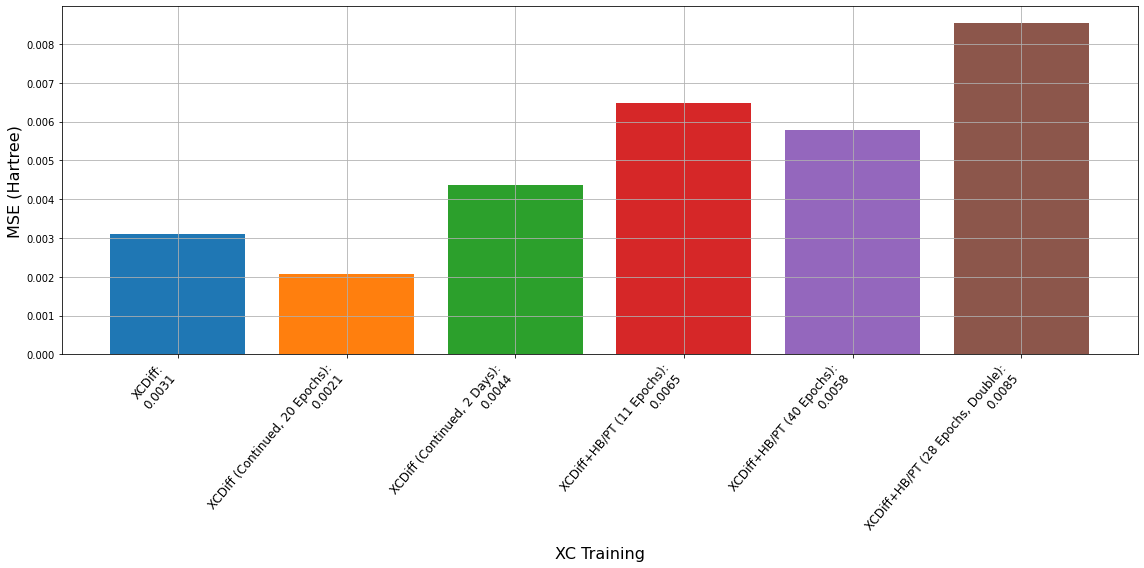

In [23]:
f = plt.figure(figsize=(16,8))
ax = f.add_subplot(111)
count = 0
xtlabs = []
ax.grid()
for k,v in errd.items():
    print(k, v[1], count)
    lab = labels[k]+':\n{:3.4f}'.format(v[1])
    print(lab)
    ax.bar(count, v[1], label=lab)
    xtlabs.append(lab)
    count += 1
ax.set_xticks(np.arange(0, count))
ax.set_xticklabels(xtlabs, fontsize=12, rotation=50, ha='right')
ax.set_ylabel("MSE (Hartree)", fontsize=16)
ax.set_xlabel("XC Training", fontsize=16)
plt.tight_layout()

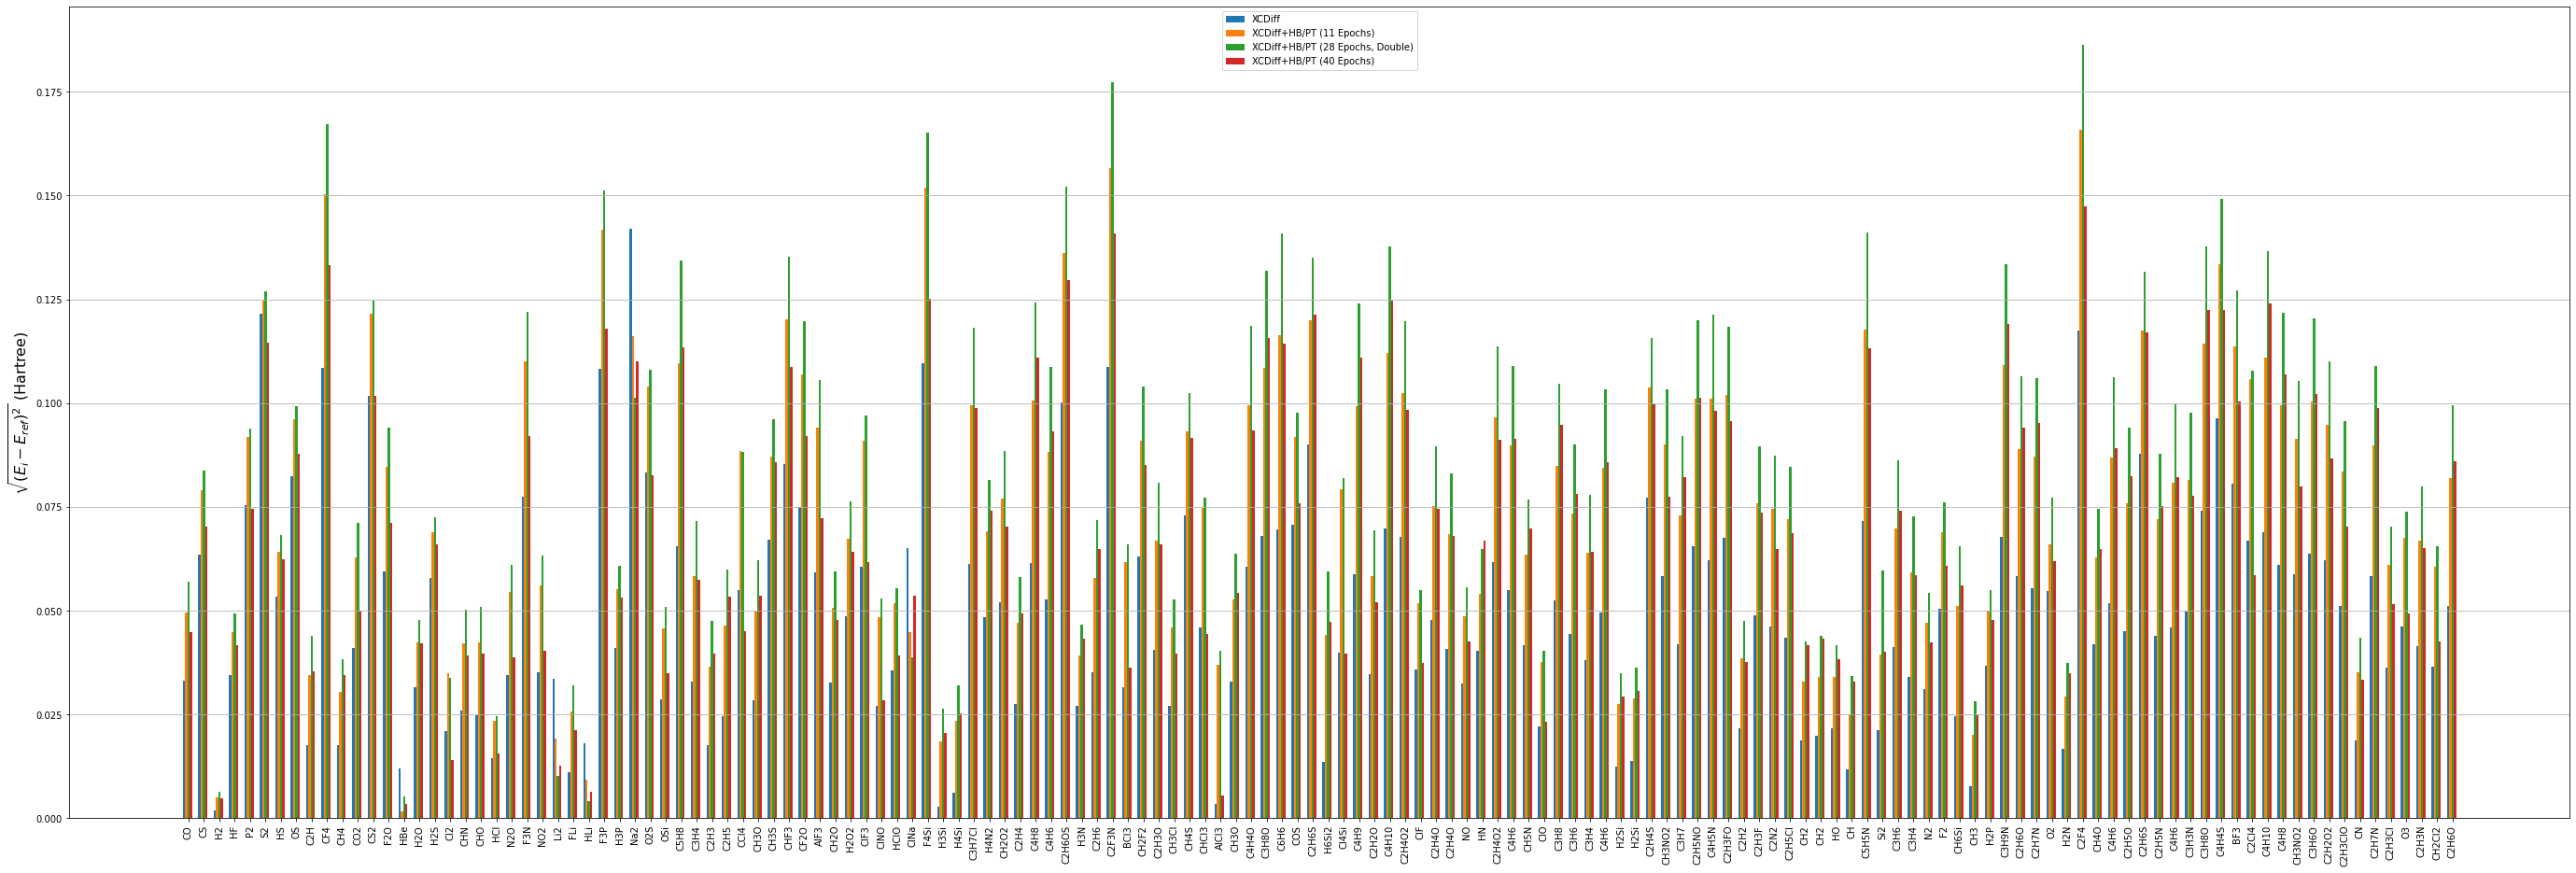

In [6]:
f = plt.figure(figsize=(48,16))
ax = f.add_subplot(111)
ax.grid()
ax.xaxis.grid(False)
def gen_xs_bar(*args, **kwargs):
    midsep = kwargs.get('midsep', 1)
    width = kwargs.get('width', midsep/(len(args)+2))
    xs = []
    start = -len(args)//2
    for iarg in range(len(args)):
        arg = args[iarg]
        argxs = []
        for igroup in range(len(arg)):
            argxs.append(igroup*midsep+start*width)
        start += 1
        xs.append(argxs)
    return xs
midsep = len(errd)+1
width = 0.75
errs = [(labels[k], errd[k][0]) for k in sorted(list(errd.keys()))]
labs = [i[0] for i in errs]
errp = [i[1] for i in errs]
xs = gen_xs_bar(*errp, width=width, midsep=midsep)
for i in range(len(xs)):
    x = xs[i]
    e = errp[i]
    ax.bar(x, e, width=width, label=labs[i])
ax.set_xticks([midsep*i for i in range(len(ref))])
ax.set_xticklabels([at.get_chemical_formula() for at in ref], rotation=90)
ax.set_ylabel('$\\sqrt{(E_i-E_{ref})^2}$ (Hartree)', fontsize=16)
plt.legend(loc='upper center')
plt.show()

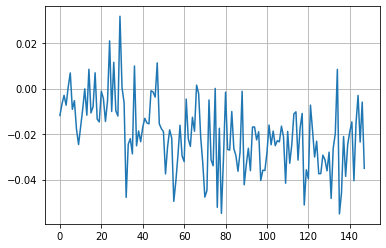

In [16]:
plt.plot(np.array(errp[0])-np.array(errp[3]))
plt.grid()

In [2]:
#HB
hb = gto.M(atom='''O 1.317021 -0.128356 0.006258;
                    H 1.527437 0.387478 -0.795622;
                    H 1.505382 0.474880 0.750724;
                    O -1.017021 0.128356 0.006258;
                    H -1.227437 -0.387478 -0.795622; 
                    H -1.205382 -0.474880 0.750724''',
            basis='def2-TZVPD', unit='angstrom')
hb.verbose = 5
hb.charge = 1
hb.spin = 1

#PT
#equilibrium hemibonded configuration: r_{OO} = 2.05 \AA.
pt = gto.M(atom='''O 1.310944 -0.092374  0.053983;
                   H 1.955110  0.571413 -0.263648;
                   H -0.101366  0.045774 -0.012031;
                   O -1.149037  0.029559 -0.084434;
                   H -1.608104  0.722348  0.414070;
                   H -1.540923 -0.836961  0.105186''',
            basis='def2-TZVPD')
pt.verbose = 5
pt.charge = 1
pt.spin = 1

In [3]:
def eval_xc(xc_code, rho, spin=0, relativity=0, deriv=1, verbose=None):
    """ Evaluation for grid-based models (not atomic)
        See pyscf documentation of eval_xc
    """
    inp = {}
    if spin == 0:
        if rho.ndim == 1:
            rho = rho.reshape(1, -1)
        inp['rho'] = rho[0]
        if len(rho) > 1:
            dx, dy, dz = rho[1:4]
            gamma = (dx**2 + dy**2 + dz**2)
            inp['sigma'] = gamma
        if len(rho) > 4:
            inp['lapl'] = rho[4]
            inp['tau'] = rho[5]
    else:
        rho_a, rho_b = rho
        if rho_a.ndim == 1:
            rho_a = rho_a.reshape(1, -1)
            rho_b = rho_b.reshape(1, -1)
        inp['rho'] = np.stack([rho_a[0], rho_b[0]])
        if len(rho_a) > 1:
            dxa, dya, dza = rho_a[1:4]
            dxb, dyb, dzb = rho_b[1:4]
            gamma_a = (dxa**2 + dya**2 + dza**2)  #compute contracted gradients
            gamma_b = (dxb**2 + dyb**2 + dzb**2)
            gamma_ab = (dxb * dxa + dyb * dya + dzb * dza)
            inp['sigma'] = np.stack([gamma_a, gamma_ab, gamma_b])
        if len(rho_a) > 4:
            inp['lapl'] = np.stack([rho_a[4], rho_b[4]])
            inp['tau'] = np.stack([rho_a[5], rho_b[5]])

    parsed_xc = pylibnxc.pyscf.utils.parse_xc_code(xc_code)
    total_output = {'v' + key: 0.0 for key in inp}
    total_output['zk'] = 0
    #print(parsed_xc)
    for code, factor in parsed_xc[1]:
        model = pylibnxc.LibNXCFunctional(xc_code, kind='grid')
        output = model.compute(inp)
        for key in output:
            if output[key] is not None:
                total_output[key] += output[key] * factor

    exc, vlapl, vtau, vrho, vsigma = [total_output.get(key,None)\
      for key in ['zk','vlapl','vtau','vrho','vsigma']]

    vxc = (vrho, vsigma, vlapl, vtau)
    fxc = None  # 2nd order functional derivative
    kxc = None  # 3rd order functional derivative
    return exc, vxc, fxc, kxc

def KS(mol, method, model_path='', nxc_kind='grid', **kwargs):
    """ Wrapper for the pyscf RKS and UKS class
    that uses a libnxc functionals
    """
    #hyb = kwargs.get('hyb', 0)
    mf = method(mol, **kwargs)
    if model_path != '':
        if nxc_kind.lower() == 'atomic':
            model = get_nxc_adapter('pyscf', model_path)
            mf.get_veff = veff_mod_atomic(mf, model)
        elif nxc_kind.lower() == 'grid':
            parsed_xc = pylibnxc.pyscf.utils.parse_xc_code(model_path)
            dft.libxc.define_xc_(mf._numint,
                                 eval_xc,
                                 pylibnxc.pyscf.utils.find_max_level(parsed_xc),
                                 hyb=parsed_xc[0][0])
            mf.xc = model_path
        else:
            raise ValueError(
                "{} not a valid nxc_kind. Valid options are 'atomic' or 'grid'"
                .format(nxc_kind))
    return mf

In [4]:
_, hbm = gen_mf_mol(hb, xc='notnull', grid_level=5, nxc=True)
_, ptm = gen_mf_mol(pt, xc='notnull', grid_level=5, nxc=True)

Building grids...
atom O rad-grids = 105, ang-grids = [ 50  50  50  50  50  50  50  50  50  50  50  50  50  50  50  50  50  50
  50  50  50  50  50  50  50  50  50  50  50  50  50  86  86  86  86  86
  86  86  86  86  86  86  86  86 590 590 590 590 590 590 590 590 590 770
 770 770 770 770 770 770 770 770 770 770 770 770 770 770 770 770 770 770
 770 770 770 770 770 770 770 770 590 590 590 590 590 590 590 590 590 590
 590 590 590 590 590 590 590 590 590 590 590 590 590 590 590]
atom H rad-grids = 70, ang-grids = [ 50  50  50  50  50  50  50  50  50  50  50  50  50  50  50  50  50  50
  50  50  86  86  86  86  86 434 434 434 434 434 434 590 590 590 590 590
 590 590 590 590 590 590 590 590 590 590 590 590 590 434 434 434 434 434
 434 434 434 434 434 434 434 434 434 434 434 434 434 434 434 434]
tot grids = 182108
METHOD GENERATED: functools.partial(<function KS at 0x7f6a2774f3b0>, method=<function UKS at 0x7f6a15320320>)
Building grids...
atom O rad-grids = 105, ang-grids = [ 50  50  50  50

In [5]:
xcdwp = '/home/awills/Documents/Research/swxcd/eval/xcdw5/MODEL_MGGA_e29_day4/xc'
xcdp = '/home/awills/Documents/Research/dpyscfl/models/xcdiff/MODEL_MGGA'
hbmf = KS(hb, hbm, model_path=xcdp, nxc_kind='grid')
ptmf = KS(pt, ptm, model_path=xcdp, nxc_kind='grid')

In [6]:
hbmf.grids.level = 5
hbmf.density_fit()
hbmf.kernel()

ptmf.grids.level = 5
ptmf.density_fit()
ptmf.kernel()



******** <class 'pyscf.dft.uks.UKS'> ********
method = UKS-UHF
initial guess = minao
damping factor = 0
level_shift factor = 0
DIIS = <class 'pyscf.scf.diis.CDIIS'>
diis_start_cycle = 1
diis_space = 8
SCF conv_tol = 1e-09
SCF conv_tol_grad = None
SCF max_cycles = 50
direct_scf = True
direct_scf_tol = 1e-13
chkfile to save SCF result = /home/awills/Documents/Research/dpyscfl/notebooks/tmpm5whttl6
max_memory 4000 MB (current use 434 MB)
number electrons alpha = 10  beta = 9
XC library pyscf.dft.libxc version 5.1.7
    S. Lehtola, C. Steigemann, M. J. Oliveira, and M. A. Marques, SoftwareX 7, 1 (2018)
XC functionals = /home/awills/Documents/Research/dpyscfl/models/xcdiff/MODEL_MGGA


KeyError: 'Unknown compound XC functional  /HOME/AWILLS/DOCUMENTS/RESEARCH/DPYSCFL/MODELS/XCDIFF/MODEL_MGGA'

In [43]:
pxc = pylibnxc.pyscf.utils.parse_xc_code(xcdp)
pxcl = pylibnxc.pyscf.utils.find_max_level(pxc)
print(pxc, pxcl)

([0, 0, 0], [('/HOME/AWILLS/DOCUMENTS/RESEARCH/DPYSCFL/MODELS/XCDIFF/MODEL_MGGA', 1)]) MGGA


In [38]:
KS?

In [46]:
del dft

In [45]:
pylibnxc.dft?

Object `pylibnxc.dft` not found.


In [47]:
dft?

Object `dft` not found.


In [48]:
import pylibnxc

In [49]:
dft?

Object `dft` not found.
